# Epistatic Interactions
This does a better job than the other notebooks, and is based on the code from [Phillips et al.](https://elifesciences.org/articles/71393#s4)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import pandas as pd
# to plot regression
import matplotlib.pyplot as plt
import seaborn as sns


mutations_9114 = ['S29F', 'N30S', 'N31S', 'S52I', 'S56T', 'T57A', 'A58N',
                  'S70T', 'I73K', 'F74S', 'S75T', 'N76S', 'N82AS', 'T83R', 'F91Y', 'S100BY']
mutations_6261 = ['P28T', 'R30S', 'T57A', 'K58N', 'P61Q',
                  'D73E', 'F74S', 'A75T', 'G76S', 'V78A', 'V100L']


In [19]:
pwd

'/home/kyroyo/rosetta-antibody-ddgs/raw_datasets'

## Read in data

In [33]:
data = pd.read_csv("~/rosetta-antibody-ddgs/raw_datasets/full_data.csv")

# Subsetting for phillips data
new_data = data[~data["Source"].str.contains("Phillips")]
data = data[data["Source"].str.contains("Phillips")]

# For fitting up to 5 mutations
# mut_1 = data.loc[data["LD"] == 1]
# mut_2 = data.loc[data["LD"] == 2]
# mut_3 = data.loc[data["LD"] == 3]
# mut_4 = data.loc[data["LD"] == 4]
# mut_5 = data.loc[data["LD"] == 5]
# mut_2 = mut_2.drop_duplicates(subset="ddG(kcal/mol)", keep=False).copy()
# mut_3 = mut_3.drop_duplicates(subset="ddG(kcal/mol)", keep=False).copy()
# mut_4 = mut_4.drop_duplicates(subset="ddG(kcal/mol)", keep=False).copy()
# mut_5 = mut_5.drop_duplicates(subset="ddG(kcal/mol)", keep=False).copy()

# dump_data = pd.concat([mut_1, mut_2, mut_3, mut_4, mut_5]
#                       ).reset_index(drop=True)
dump_data = data.drop_duplicates(subset="ddG(kcal/mol)", keep=False).copy().reset_index(drop=True)
print(dump_data.head())


   #PDB                                          Mutations  ddG(kcal/mol)  \
0  3GBN  H:R30S;H:T57A;H:K58N;H:P61Q;H:D73E;H:A75T;H:G7...      -0.489763   
1  3GBN                        H:T57A;H:K58N;H:P61Q;H:A75T      -0.439831   
2  3GBN                 H:P28T;H:P61Q;H:D73E;H:A75T;H:G76S      -0.439223   
3  3GBN         H:P28T;H:P61Q;H:D73E;H:A75T;H:G76S;H:V100L      -0.404429   
4  3GBN                H:T57A;H:K58N;H:P61Q;H:A75T;H:V100L      -0.364320   

                 Source  LD  
0  Phillips et al. 2021   8  
1  Phillips et al. 2021   4  
2  Phillips et al. 2021   5  
3  Phillips et al. 2021   6  
4  Phillips et al. 2021   5  


In [34]:
mlb9114 = MultiLabelBinarizer(classes=mutations_9114, sparse_output=True)
mlb6261 = MultiLabelBinarizer(classes=mutations_6261, sparse_output=True)

dump_data9114 = dump_data.loc[dump_data["#PDB"] == "4FQY"].copy()
dump_data6261 = dump_data.loc[dump_data["#PDB"] == "3GBN"].copy()

dump_data9114.loc[:, ("Mutations")] = dump_data9114.loc[:, ("Mutations")].apply(
    lambda x: re.split(";", re.sub(r"\w:(\w+)", r"\1", x))).copy()
dump_data6261.loc[:, ("Mutations")] = dump_data6261.loc[:, ("Mutations")].apply(
    lambda x: re.split(";", re.sub(r"\w:(\w+)", r"\1", x))).copy()

dump_data9114 = dump_data9114.join(pd.DataFrame.sparse.from_spmatrix(
    mlb9114.fit_transform(dump_data9114.pop('Mutations')),
    index=dump_data9114.index,
    columns=mlb9114.classes_))
dump_data9114.drop("Source", axis=1, inplace=True)
dump_data6261 = dump_data6261.join(pd.DataFrame.sparse.from_spmatrix(
    mlb6261.fit_transform(dump_data6261.pop('Mutations')),
    index=dump_data6261.index,
    columns=mlb6261.classes_))
dump_data6261.drop("Source", axis=1, inplace=True)
print(dump_data9114.head())
print(dump_data6261.head())


      #PDB  ddG(kcal/mol)  LD  S29F  N30S  N31S  S52I  S56T  T57A  A58N  S70T  \
2033  4FQY       1.473501   5     1     0     0     0     0     1     0     1   
2034  4FQY       0.864929   5     0     0     0     0     1     0     1     1   
2035  4FQY       1.797673   6     0     0     0     0     1     1     1     0   
2036  4FQY       1.481539   6     0     0     0     0     0     1     1     0   
2037  4FQY       1.284476   5     1     0     0     0     1     0     1     0   

      I73K  F74S  S75T  N76S  N82AS  T83R  F91Y  S100BY  
2033     0     0     0     0      0     1     1       0  
2034     0     0     0     0      1     1     0       0  
2035     0     0     0     1      0     1     1       0  
2036     0     0     0     1      1     0     1       1  
2037     0     0     1     0      0     1     0       0  
   #PDB  ddG(kcal/mol)  LD  P28T  R30S  T57A  K58N  P61Q  D73E  F74S  A75T  \
0  3GBN      -0.489763   8     0     1     1     1     1     1     0     1   
1  3GBN  

# Making Arrays for Regression

In [35]:
# All data 6261
affinities_6261 = dump_data6261[[
    "ddG(kcal/mol)"]].values.flatten()
print(affinities_6261.shape)
genotypes_6261 = np.array(dump_data6261[[
                            x for x in mutations_6261]].copy(), dtype=np.float64)
print(genotypes_6261.shape)

# # Partitioned data 6261
# affinities_6261_1 = dump_data6261.loc[dump_data6261["LD"] == 1][["ddG(kcal/mol)"]].values.flatten()
# print(affinities_6261_1.shape)
# genotypes_6261_1 = np.array(
#     dump_data6261.loc[dump_data6261["LD"] == 1][[x for x in mutations_6261]].copy(), dtype=np.float64)
# print(genotypes_6261_1.shape)
# affinities_6261_2 = dump_data6261.loc[dump_data6261["LD"] <= 2][["ddG(kcal/mol)"]].values.flatten()
# print(affinities_6261_2.shape)
# genotypes_6261_2 = np.array(
#     dump_data6261.loc[dump_data6261["LD"] <= 2][[x for x in mutations_6261]].copy(), dtype=np.float64)
# print(genotypes_6261_2.shape)
# affinities_6261_3 = dump_data6261.loc[dump_data6261["LD"] <= 3][["ddG(kcal/mol)"]].values.flatten()
# print(affinities_6261_3.shape)
# genotypes_6261_3 = np.array(
#     dump_data6261.loc[dump_data6261["LD"] <= 3][[x for x in mutations_6261]].copy(), dtype=np.float64)
# print(genotypes_6261_3.shape)
# affinities_6261_4 = dump_data6261.loc[dump_data6261["LD"] <= 4][["ddG(kcal/mol)"]].values.flatten()
# print(affinities_6261_4.shape)
# genotypes_6261_4 = np.array(
#     dump_data6261.loc[dump_data6261["LD"] <= 4][[x for x in mutations_6261]].copy(), dtype=np.float64)
# print(genotypes_6261_4.shape)

# All data 9114
affinities_9114 = dump_data9114[[
    "ddG(kcal/mol)"]].values.flatten()
print(affinities_9114.shape)
genotypes_9114 = np.array(dump_data9114[[
                            x for x in mutations_9114]].copy(), dtype=np.float64)
print(genotypes_9114.shape)

# # partitioned data 9114
# affinities_9114_1 = dump_data9114.loc[dump_data9114["LD"] == 1][[
#     "ddG(kcal/mol)"]].values.flatten()
# print(affinities_9114_1.shape)
# genotypes_9114_1 = np.array(dump_data9114.loc[dump_data9114["LD"] == 1][[
#                             x for x in mutations_9114]].copy(), dtype=np.float64)
# print(genotypes_9114_1.shape)
# affinities_9114_2 = dump_data9114.loc[dump_data9114["LD"] <= 2][["ddG(kcal/mol)"]].values.flatten()
# print(affinities_9114_2.shape)
# genotypes_9114_2 = np.array(dump_data9114.loc[dump_data9114["LD"] <= 2][[x for x in mutations_9114]].copy(), dtype=np.float64)
# print(genotypes_9114_2.shape)
# affinities_9114_3 = dump_data9114.loc[dump_data9114["LD"] <= 3][[
#     "ddG(kcal/mol)"]].values.flatten()
# print(affinities_9114_3.shape)
# genotypes_9114_3 = np.array(dump_data9114.loc[dump_data9114["LD"] <= 3][[
#                             x for x in mutations_9114]].copy(), dtype=np.float64)
# print(genotypes_9114_3.shape)
# affinities_9114_4 = dump_data9114.loc[dump_data9114["LD"] <= 4][[
#     "ddG(kcal/mol)"]].values.flatten()
# print(affinities_9114_4.shape)
# genotypes_9114_4 = np.array(dump_data9114.loc[dump_data9114["LD"] <= 4][[
#                             x for x in mutations_9114]].copy(), dtype=np.float64)
# print(genotypes_9114_4.shape)

(2033,)
(2033, 11)
(7173,)
(7173, 16)


## CV to choose optimal order of interaction

### 6261

In [36]:
num_folds = 10
max_order = 4

# set up permutation
np.random.seed(7722)
indices_permuted_6261 = np.random.permutation(np.arange(len(genotypes_6261)))
size_test_6261 = int(1.0/float(num_folds)*len(genotypes_6261))
size_train_6261 = len(genotypes_6261)-size_test_6261
print(size_test_6261, size_train_6261)

# lists to store r squared values
rsq_train_list_6261 = np.zeros((max_order+1, num_folds))
rsq_test_list_6261 = np.zeros((max_order+1, num_folds))


# loop over CV folds
for f in range(num_folds):

    # get train & test sets
    start = int(f*size_test_6261)
    stop = int((f+1)*size_test_6261)
    genos_train_6261 = np.concatenate(
        (genotypes_6261[indices_permuted_6261[:start]], genotypes_6261[indices_permuted_6261[stop:]]))
    genos_test_6261 = genotypes_6261[indices_permuted_6261[start:stop]]
    affinities_train_6261 = np.concatenate(
        (affinities_6261[indices_permuted_6261[:start]], affinities_6261[indices_permuted_6261[stop:]]))
    affinities_test_6261 = affinities_6261[indices_permuted_6261[start:stop]]

    print('Fold: ', f)

    # initialize zero-order (intercept-only) model
    genos_train_6261_previous = np.full(len(genos_train_6261), 1.0)
    genos_test_6261_previous = np.full(len(genos_test_6261), 1.0)

    reg_6261_previous = sm.OLS(affinities_train_6261, genos_train_6261_previous).fit()
    reg_6261_coefs_previous = reg_6261_previous.params

    rsquared_train_6261_previous = reg_6261_previous.rsquared
    rsquared_test_6261_previous = 1-np.sum((affinities_test_6261-reg_6261_previous.predict(
        genos_test_6261_previous))**2)/np.sum((affinities_test_6261-np.mean(affinities_test_6261))**2)
    rsq_train_list_6261[0, f] = rsquared_train_6261_previous
    rsq_test_list_6261[0, f] = rsquared_test_6261_previous

    # mean_pheno_train = np.mean(affinities_train_6261)
    # mean_pheno_test = np.mean(affinities_test_6261)

    # fit models of increasing order
    for order in range(1, max_order+1):
        #print('Order: ',str(order))
        poly_6261_current = PolynomialFeatures(order, interaction_only=True)
        genos_train_6261_current = poly_6261_current.fit_transform(genos_train_6261)
        genos_test_6261_current = poly_6261_current.fit_transform(genos_test_6261)

        reg_6261_current = sm.OLS(affinities_train_6261, genos_train_6261_current).fit()
        reg_6261_coefs_current = reg_6261_current.params
        # print(reg_6261_coefs_current) # FIXME
        reg_6261_CIs_current = reg_6261_current.conf_int(alpha=0.05, cols=None)
        reg_6261_stderr = reg_6261_current.bse
        # NOTE: Use mse_resid for BIC if you choose to use that

        rsquared_train_6261_current = reg_6261_current.rsquared
        rsquared_test_6261_current = 1-np.sum((affinities_test_6261-reg_6261_current.predict(
            genos_test_6261_current))**2)/np.sum((affinities_test_6261-np.mean(affinities_test_6261))**2)
        rsq_train_list_6261[order, f] = rsquared_train_6261_current
        rsq_test_list_6261[order, f] = rsquared_test_6261_current


# average over folds
mean_rsq_train_6261 = np.mean(rsq_train_list_6261, axis=1)
stdev_rsq_train_6261 = np.std(rsq_train_list_6261, axis=1)
mean_rsq_test_6261 = np.mean(rsq_test_list_6261, axis=1)
stdev_rsq_test_6261 = np.std(rsq_test_list_6261, axis=1)

optimal_6261_order = np.argmax(mean_rsq_test_6261)
print('Optimal order, 6261: ', optimal_6261_order)


203 1830
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
Optimal order, 6261:  4


In [37]:
# print CV results to file
with open('./CR6261_CV_rsquared.csv', 'w') as writefile:
    rsq_writer = csv.writer(writefile)
    rsq_writer.writerow(['Type', 'Order', 'Mean', 'Std'])
    for i in range(len(mean_rsq_train_6261)):
        rsq_writer.writerow(
            ['Train', str(i), mean_rsq_train_6261[i], stdev_rsq_train_6261[i]])
    for i in range(len(mean_rsq_test_6261)):
        rsq_writer.writerow(
            ['Test', str(i), mean_rsq_test_6261[i], stdev_rsq_test_6261[i]])
    writefile.close()

### 9114

In [42]:
num_folds = 10
max_order = 4

# set up permutation
np.random.seed(7722)
indices_permuted_9114 = np.random.permutation(np.arange(len(genotypes_9114)))
size_test_9114 = int(1.0/float(num_folds)*len(genotypes_9114))
size_train_9114 = len(genotypes_9114)-size_test_9114
print(size_test_9114, size_train_9114)

# lists to store r squared values
rsq_train_list_9114 = np.zeros((max_order+1, num_folds))
rsq_test_list_9114 = np.zeros((max_order+1, num_folds))


# loop over CV folds
for f in range(num_folds):

    # get train & test sets
    start = int(f*size_test_9114)
    stop = int((f+1)*size_test_9114)
    genos_train_9114 = np.concatenate(
        (genotypes_9114[indices_permuted_9114[:start]], genotypes_9114[indices_permuted_9114[stop:]]))
    genos_test_9114 = genotypes_9114[indices_permuted_9114[start:stop]]
    phenos_train_9114 = np.concatenate(
        (affinities_9114[indices_permuted_9114[:start]], affinities_9114[indices_permuted_9114[stop:]]))
    phenos_test_9114 = affinities_9114[indices_permuted_9114[start:stop]]

    print('Fold: ', f)

    # initialize zero-order (intercept-only) model
    genos_train_9114_previous = np.full(len(genos_train_9114), 1.0)
    genos_test_9114_previous = np.full(len(genos_test_9114), 1.0)

    reg_9114_previous = sm.OLS(phenos_train_9114, genos_train_9114_previous).fit()
    reg_9114_coefs_previous = reg_9114_previous.params

    rsquared_train_9114_previous = reg_9114_previous.rsquared
    rsquared_test_9114_previous = 1-np.sum((phenos_test_9114-reg_9114_previous.predict(
        genos_test_9114_previous))**2)/np.sum((phenos_test_9114-np.mean(phenos_test_9114))**2)
    rsq_train_list_9114[0, f] = rsquared_train_9114_previous
    rsq_test_list_9114[0, f] = rsquared_test_9114_previous

    mean_pheno_train = np.mean(phenos_train_9114)
    mean_pheno_test = np.mean(phenos_test_9114)

    # fit models of increasing order
    for order in range(1, max_order+1):
        #print('Order: ',str(order))
        poly_9114_current = PolynomialFeatures(order, interaction_only=True)
        genos_train_9114_current = poly_9114_current.fit_transform(genos_train_9114)
        genos_test_9114_current = poly_9114_current.fit_transform(genos_test_9114)

        reg_9114_current = sm.OLS(phenos_train_9114, genos_train_9114_current).fit()
        reg_9114_coefs_current = reg_9114_current.params
        reg_9114_CIs_current = reg_9114_current.conf_int(alpha=0.05, cols=None)
        reg_9114_stderr = reg_9114_current.bse

        rsquared_train_9114_current = reg_9114_current.rsquared
        rsquared_test_9114_current = 1-np.sum((phenos_test_9114-reg_9114_current.predict(
            genos_test_9114_current))**2)/np.sum((phenos_test_9114-np.mean(phenos_test_9114))**2)
        rsq_train_list_9114[order, f] = rsquared_train_9114_current
        rsq_test_list_9114[order, f] = rsquared_test_9114_current


# average over folds
mean_rsq_train_9114 = np.mean(rsq_train_list_9114, axis=1)
stdev_rsq_train_9114 = np.std(rsq_train_list_9114, axis=1)
mean_rsq_test_9114 = np.mean(rsq_test_list_9114, axis=1)
stdev_rsq_test_9114 = np.std(rsq_test_list_9114, axis=1)

optimal_9114_order = np.argmax(mean_rsq_test_9114)
print('Optimal order, 9114: ', optimal_9114_order)


717 6456
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
Optimal order, 9114:  3


In [43]:
# print CV results to file
with open('./9114_CV_rsquared.csv','w') as writefile:
    rsq_writer = csv.writer(writefile)
    rsq_writer.writerow(['Optimal order: '+str(optimal_9114_order)])
    rsq_writer.writerow(['Type','Order','Mean','Std'])
    for i in range(len(mean_rsq_train_9114)):
        rsq_writer.writerow(['Train',str(i),mean_rsq_train_9114[i],stdev_rsq_train_9114[i]])
    for i in range(len(mean_rsq_test_9114)):
        rsq_writer.writerow(['Test',str(i),mean_rsq_test_9114[i],stdev_rsq_test_9114[i]])
    writefile.close()
    

## Fit final models

### 6261

Order:  1
9
Params:  12
Performance:  0.7189706389265444


ORDER: 1


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     5196.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:31:42   Log-Likelihood:                -1760.6
No. Observations:                2033   AIC:                             3525.
Df Residuals:                    2031   BIC:                             3536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

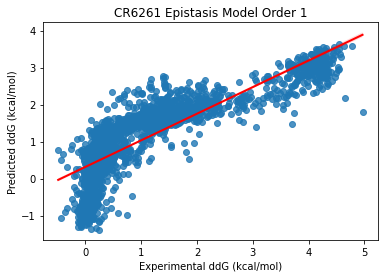

Order:  2
21
Params:  67
Performance:  0.8998779856298994


ORDER: 2


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 1.825e+04
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:31:45   Log-Likelihood:                -939.66
No. Observations:                2033   AIC:                             1883.
Df Residuals:                    2031   BIC:                             1895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

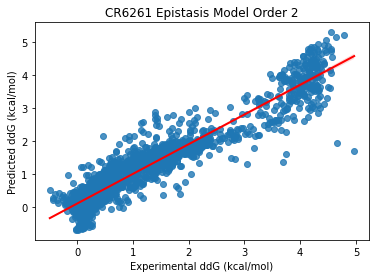

<Figure size 432x288 with 0 Axes>

In [50]:
# fit models of increasing order
from patsy import dmatrices
for order in range(1, 3): # optimal_6261_order+2

    genotypes_6261_permuted = genotypes_6261[indices_permuted_6261]
    affinities_6261_permuted = affinities_6261[indices_permuted_6261]
    print('Order: ', str(order))
    poly_6261_current = PolynomialFeatures(order, interaction_only=True)
    genotypes_6261_current = poly_6261_current.fit_transform(genotypes_6261_permuted)

    # fit
    reg_6261_current = sm.OLS(affinities_6261_permuted, genotypes_6261_current).fit()
    reg_6261_coefs_current = reg_6261_current.params
    reg_6261_CIs_current = reg_6261_current.conf_int(
        alpha=0.05/float(len(reg_6261_coefs_current)), cols=None)
    reg_6261_stderr = reg_6261_current.bse
    reg_6261_pvalues = reg_6261_current.pvalues

    num_sig = len(np.where(reg_6261_pvalues < 0.05 /
                  float(len(reg_6261_coefs_current)))[0])
    print(num_sig)

    predicted_phenos_permuted_6261 = reg_6261_current.predict(genotypes_6261_current)
    rsquared_6261_current = reg_6261_current.rsquared
    print('Params: ', len(reg_6261_coefs_current))
    print('Performance: ', rsquared_6261_current)

    # write model to file
    if order > 0:
        coef_names = poly_6261_current.get_feature_names_out(
            input_features=mutations_6261)
        with open('./6261_'+str(order)+'order.txt', 'w') as writefile:
            coef_writer = csv.writer(writefile, delimiter='\t')
            coef_writer.writerow(['Params: ', len(reg_6261_coefs_current)])
            coef_writer.writerow(['Performance: ', rsquared_6261_current])
            coef_writer.writerow(
                ['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper'])
            coef_writer.writerow(['Intercept', reg_6261_coefs_current[0]])
            for i in range(1, len(reg_6261_coefs_current)):
                coef_writer.writerow([','.join(coef_names[i].split(' ')), reg_6261_coefs_current[i], reg_6261_stderr[i],
                                      reg_6261_pvalues[i], reg_6261_CIs_current[i][0], reg_6261_CIs_current[i][1]])
            writefile.close()

        df = pd.DataFrame({
            "Predicted": predicted_phenos_permuted_6261,
            "Actual": affinities_6261_permuted
        })

        y, X = dmatrices("Predicted ~ Actual",
                    data=df, return_type='dataframe')

        model = sm.OLS(y, X)
        results = model.fit()
        print(f"\n\nORDER: {order}\n\n")
        print(results.summary())
        plot = sns.regplot(x="Actual", y="Predicted", data=df, line_kws={'lw': 2, 'color': 'red'})
        plt.title(f"CR6261 Epistasis Model Order {order}")
        plt.xlabel("Experimental ddG (kcal/mol)")
        plt.ylabel("Predicted ddG (kcal/mol)")
        plt.show()
        # plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
        plt.clf()


### 9114

Order:  1
17
Params:  17
Performance:  0.7820407464051333


ORDER: 1


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                 2.573e+04
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:32:06   Log-Likelihood:                -2644.9
No. Observations:                7173   AIC:                             5294.
Df Residuals:                    7171   BIC:                             5308.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

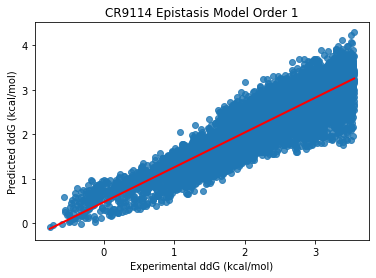

Order:  2
63
Params:  137
Performance:  0.9344332421017346


ORDER: 2


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 1.022e+05
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:32:08   Log-Likelihood:                 1024.8
No. Observations:                7173   AIC:                            -2046.
Df Residuals:                    7171   BIC:                            -2032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

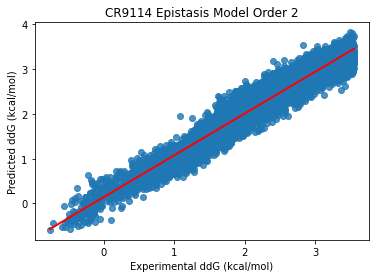

<Figure size 432x288 with 0 Axes>

In [51]:
# fit models of increasing order
for order in range(1, 3):  # optimal_9114_order+2

    genotypes_9114_permuted = genotypes_9114[indices_permuted_9114]
    affinities_9114_permuted = affinities_9114[indices_permuted_9114]
    print('Order: ', str(order))
    poly_9114_current = PolynomialFeatures(order, interaction_only=True)
    genotypes_9114_current = poly_9114_current.fit_transform(genotypes_9114_permuted)

    # fit
    reg_9114_current = sm.OLS(affinities_9114_permuted, genotypes_9114_current).fit()
    reg_9114_coefs_current = reg_9114_current.params
    reg_9114_CIs_current = reg_9114_current.conf_int(
        alpha=0.05/float(len(reg_9114_coefs_current)), cols=None)
    reg_9114_stderr = reg_9114_current.bse
    reg_9114_pvalues = reg_9114_current.pvalues

    num_sig = len(np.where(reg_9114_pvalues < 0.05 /
                  float(len(reg_9114_coefs_current)))[0])
    print(num_sig)

    predicted_phenos_permuted_9114 = reg_9114_current.predict(genotypes_9114_current)
    rsquared_9114_current = reg_9114_current.rsquared
    print('Params: ', len(reg_9114_coefs_current))
    print('Performance: ', rsquared_9114_current)

    # write model to file
    if order > 0:
        coef_names = poly_9114_current.get_feature_names_out(
            input_features=mutations_9114)
        with open('./9114_'+str(order)+'order.txt', 'w') as writefile:
            coef_writer = csv.writer(writefile, delimiter='\t')
            coef_writer.writerow(['Params: ', len(reg_9114_coefs_current)])
            coef_writer.writerow(['Performance: ', rsquared_9114_current])
            coef_writer.writerow(
                ['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper'])
            coef_writer.writerow(['Intercept', reg_9114_coefs_current[0]])
            for i in range(1, len(reg_9114_coefs_current)):
                coef_writer.writerow([','.join(coef_names[i].split(' ')), reg_9114_coefs_current[i], reg_9114_stderr[i],
                                      reg_9114_pvalues[i], reg_9114_CIs_current[i][0], reg_9114_CIs_current[i][1]])
            writefile.close()

        df = pd.DataFrame({
            "Predicted": predicted_phenos_permuted_9114,
            "Actual": affinities_9114_permuted
        })

        y, X = dmatrices("Predicted ~ Actual",
                    data=df, return_type='dataframe')

        model = sm.OLS(y, X)
        results = model.fit()
        print(f"\n\nORDER: {order}\n\n")
        print(results.summary())
        plot = sns.regplot(x="Actual", y="Predicted", data=df, line_kws={'lw': 2, 'color': 'red'})
        plt.title(f"CR9114 Epistasis Model Order {order}")
        plt.xlabel("Experimental ddG (kcal/mol)")
        plt.ylabel("Predicted ddG (kcal/mol)")
        plt.show()
        # plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
        plt.clf()
